In [81]:
import torch
import torch.nn as nn
from torch import optim 

import matplotlib.pyplot as plt 

In [3]:
from torchvision import datasets
data_path = './data-unversioned/cifar-100/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Extracting ./data-unversioned/cifar-100/cifar-10-python.tar.gz to ./data-unversioned/cifar-100/
Files already downloaded and verified


In [7]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [13]:
img, label = cifar10[99]
print("CIFAR-10 Length",len(cifar10))
img, label, class_names[label]

CIFAR-10 Length 50000


(<PIL.Image.Image image mode=RGB size=32x32 at 0x1AB70BAED48>, 1, 'automobile')

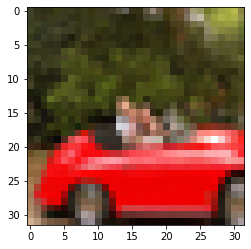

In [11]:
plt.imshow(img)
plt.show()

### ```torchvision``` module

In [14]:
from torchvision import transforms

In [16]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [20]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [21]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=to_tensor)

Files already downloaded and verified


In [25]:
img_1, _ = cifar10[99]

In [29]:
img_1.min(), img_1.max()

(tensor(0.), tensor(1.))

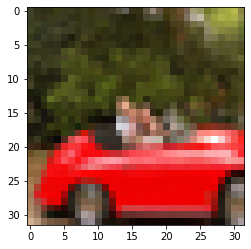

In [28]:
plt.imshow(img_1.permute(1,2,0))
plt.show()

#### Normalizing Data

In [32]:
imgs = torch.stack([img for img, _ in cifar10], dim=3)

In [33]:
imgs.shape

torch.Size([3, 32, 32, 50000])

In [46]:
mean = imgs.view(3,-1).mean(dim=1)

In [47]:
mean

tensor([0.4915, 0.4823, 0.4468])

In [48]:
std = imgs.view(3,-1).std(dim=1)

In [49]:
std

tensor([0.2470, 0.2435, 0.2616])

In [55]:
imgs.view(3,-1).shape

torch.Size([3, 51200000])

In [50]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468), 
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


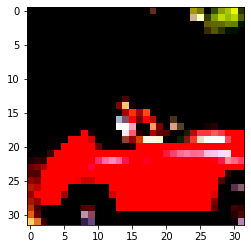

In [51]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [52]:
one = torch.ones(3,2,2)

In [53]:
one.view(3, -1)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [56]:
label_map = {0:0, 2:1}
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]

In [57]:
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [63]:
n_out = 2

bird_airplane_model = nn.Sequential(

    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
)

#### Softmax

```python

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

```

In [64]:
bird_airplane_model = nn.Sequential(

    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.Softmax(dim=1)
)

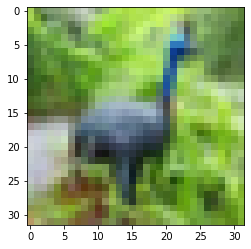

In [66]:
img, _ = cifar2[0]

plt.imshow(img.permute(1,2,0))
plt.show()

In [71]:
img_squeezed = img.view(-1).unsqueeze(0)

In [72]:
img_squeezed.shape

torch.Size([1, 3072])

In [73]:
out = bird_airplane_model(img_squeezed)
out

tensor([[0.4320, 0.5680]], grad_fn=<SoftmaxBackward>)

In [74]:
_, index = torch.max(out, dim=1)

In [76]:
_

tensor([0.5680], grad_fn=<MaxBackward0>)

#### Using Loss function NLL with LogSoftmax

In [77]:
bird_airplane_model = nn.Sequential(

    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.LogSoftmax(dim=1)
)

In [79]:
loss_fn = nn.NLLLoss()

In [84]:
learning_rate = 1e-2
optimizer = optim.SGD(bird_airplane_model.parameters(), lr=learning_rate)

n_epochs = 100
for epoch in range(n_epochs):
    for img, label in cifar2:
        out = bird_airplane_model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 1.206461
Epoch: 1, Loss: 1.466197
Epoch: 2, Loss: 1.782331
Epoch: 3, Loss: 2.174497
Epoch: 4, Loss: 2.803537
Epoch: 5, Loss: 3.222694
Epoch: 6, Loss: 3.530885
Epoch: 7, Loss: 3.814767
Epoch: 8, Loss: 4.553794
Epoch: 9, Loss: 4.301233
Epoch: 10, Loss: 5.136722
Epoch: 11, Loss: 5.548394
Epoch: 12, Loss: 6.720520
Epoch: 13, Loss: 8.018229
Epoch: 14, Loss: 9.374902
Epoch: 15, Loss: 9.468822
Epoch: 16, Loss: 8.108941
Epoch: 17, Loss: 11.318730
Epoch: 18, Loss: 10.974588
Epoch: 19, Loss: 2.632669
Epoch: 20, Loss: 6.843648
Epoch: 21, Loss: 11.526026
Epoch: 22, Loss: 12.073618
Epoch: 23, Loss: 7.605838
Epoch: 24, Loss: 7.833568
Epoch: 25, Loss: 13.120029
Epoch: 26, Loss: 3.938491
Epoch: 27, Loss: 8.801229
Epoch: 28, Loss: 8.024746
Epoch: 29, Loss: 3.548052
Epoch: 30, Loss: 5.242209
Epoch: 31, Loss: 4.558282
Epoch: 32, Loss: 6.447198


KeyboardInterrupt: 

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)
for epoch in train_loader:
    for img, label in cifar2:
        out = bird_airplane_model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

#### Accuracy

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)
